# PFAS Comments Analysis

## Setup the Environment

In [1]:
# Install required libraries (grouped)
!pip install python-docx==0.8.11 pandas transformers matplotlib seaborn langdetect nltk wordcloud

# Imports (grouped and sorted alphabetically within groups)
import os
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter
from docx import Document
from langdetect import detect
from nltk import word_tokenize, sent_tokenize, ngrams, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from transformers import pipeline
from wordcloud import WordCloud


# Download all required NLTK data (grouped and avoiding redundancy)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download('opinion_lexicon')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# Rest of your code...

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184488 sha256=9f1d77007789ab403fff9195c6b756392f3f4ae18d638fce4457570ca80dd153
  Stored in directory: /root/.cache/pip/wheels/b2/11/b8/209e41af524253c9ba6c2a8b8ecec0f98ecbc28c732512803c
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=c174b2b603d8bd955724256cff98e3a7e1fce83b30ba11da0d8ff3b1f7f10879
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built python-docx langdetect


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## Data Extraction from Word Documents

### Extract comments and save to CSV

In [4]:
def extract_comments_from_docx(file_path):
    # Load the Word document
    doc = Document(file_path)

    comments_data = []

    # Process each table in the document
    for table in doc.tables:
        # Get the first and third columns (ID and General Comments)
        try:
            id_cell = table.rows[0].cells[0].text.strip()  # First column
            comments_cell = table.rows[0].cells[2].text.strip()  # Third column

            # Extract ID (4 digits)
            if id_cell.isdigit() and len(id_cell) == 4:
                # Get only the General Comments content, removing the "General Comments:" header if present
                comments_text = comments_cell
                if comments_text.startswith("General Comments:"):
                    comments_text = comments_text[len("General Comments:"):].strip()

                comments_data.append({
                    'ID': id_cell,
                    'General Comments': comments_text
                })
        except IndexError:
            continue  # Skip malformed tables

    # Convert to DataFrame
    df = pd.DataFrame(comments_data)
    return df

# Extract comments and save to CSV
file_path = "/content/rest_pfas_rcom_part100_37876_en.docx"
comments_df = extract_comments_from_docx(file_path)

# Save to CSV
comments_df.to_csv('pfas_comments.csv', index=False)

# Display first few rows
print(comments_df.head())

# Print total number of comments extracted
print(f"\nTotal number of comments extracted: {len(comments_df)}")

     ID                                   General Comments
0  8724  Winning the War against PFAS: A Path to a PFAS...
1  8725  Based on the information presented we propose ...
2  8726  GPA is a professional organization that repres...
3  8727  See Uploaded file: GARLOCK PFAS KONSULTATION f...
4  8728  GIFAS (Groupement des Industries Françaises Aé...

Total number of comments extracted: 37


## Preprocessing the data

In [5]:
def clean_text(text):
    """Clean raw text input"""
    if not isinstance(text, str):
        return ""

    # Remove special characters and numbers (keep alphanumeric and basic punctuation)
    text = re.sub(r'[^a-zA-Z\s.,!?]', ' ', text)
    # Convert to lowercase
    return text.lower()

def remove_stopwords(tokens):
    """Remove stopwords from tokenized text"""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize_tokens(tokens):
    """Lemmatize tokens with POS tagging"""
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens)
    lemmatized = []
    for word, tag in pos_tags:
        wn_tag = {
            'J': wordnet.ADJ,
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV
        }.get(tag[0], wordnet.NOUN)
        lemmatized.append(lemmatizer.lemmatize(word, wn_tag))
    return lemmatized

def preprocess_text(text):
    """Full preprocessing pipeline"""
    cleaned = clean_text(text)
    tokens = word_tokenize(cleaned)
    filtered = remove_stopwords(tokens)
    lemmatized = lemmatize_tokens(filtered)
    return ' '.join(lemmatized)


# Apply preprocessing to all comments

comments_df['cleaned_comments'] = comments_df['General Comments'].apply(preprocess_text)

In [ ]:
comments_df.head()

,ID,General Comments,cleaned_comments
0,8724,Winning the War against PFAS: A Path to a PFAS...,win war pfas path pfas free future ceramic mem...
1,8725,Based on the information presented we propose ...,base information present propose derogation us...
2,8726,GPA is a professional organization that repres...,gpa professional organization represent french...
3,8727,See Uploaded file: GARLOCK PFAS KONSULTATION f...,see uploaded file garlock pfas konsultation fi...
4,8728,GIFAS (Groupement des Industries Françaises Aé...,gifas groupement de industry fran aises ronaut...


## Sentiment Analysis

In [6]:
sentiment_analyzer = pipeline(
    "text-classification",
    model="tabularisai/multilingual-sentiment-analysis",
    return_all_scores=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [7]:
def analyze_sentiment_batch(texts, batch_size=32, max_length=512):
    """Process texts in batches for efficiency, truncating to max_length"""
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        # Truncate each text in the batch to max_length
        truncated_batch = [text[:max_length] for text in batch]
        results.extend(sentiment_analyzer(truncated_batch))
    return results

# Run analysis on cleaned comments with truncation
sentiment_results = analyze_sentiment_batch(comments_df['General Comments'].tolist())

In [9]:
def parse_sentiment(results):
    """Parse transformer output to get dominant sentiment"""
    parsed = []
    for result in results:
        scores = {item['label']: item['score'] for item in result}
        parsed.append({
            'sentiment': max(scores, key=scores.get),
            'confidence': max(scores.values())
        })
    return parsed

sentiment_data = parse_sentiment(sentiment_results)
comments_df = pd.concat([
    comments_df,
    pd.DataFrame(sentiment_data)
], axis=1)

#We need to remove the "see attachement" comments to avoid it saved as neutral comments

In [10]:
comments_df

,ID,General Comments,cleaned_comments,sentiment,confidence
0,8724,Winning the War against PFAS: A Path to a PFAS...,win war pfas path pfas free future ceramic mem...,Very Positive,0.500749
1,8725,Based on the information presented we propose ...,base information present propose derogation us...,Negative,0.268822
2,8726,GPA is a professional organization that repres...,gpa professional organization represent french...,Neutral,0.668582
3,8727,See Uploaded file: GARLOCK PFAS KONSULTATION f...,see uploaded file garlock pfas konsultation fi...,Neutral,0.436422
4,8728,GIFAS (Groupement des Industries Françaises Aé...,gifas groupement de industry fran aises ronaut...,Very Positive,0.472940
5,8729,Please se attached document,please se attach document,Neutral,0.534553
6,8730,See attachment,see attachment,Neutral,0.502157
7,8731,-,,Positive,0.252941
8,8732,Please see confidential attachment in Section V.,please see confidential attachment section v .,Neutral,0.596689
9,8733,See the attachement,see attachement,Neutral,0.445948


### Sentiment Distribution

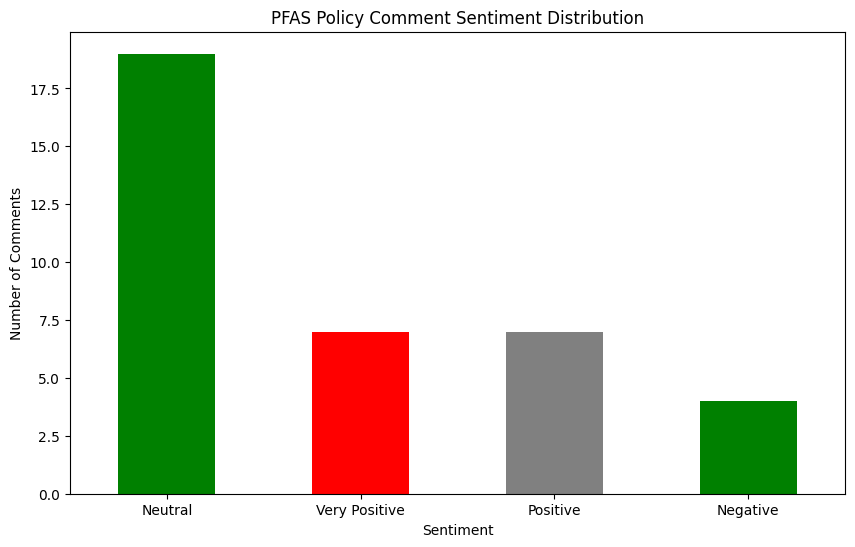

In [11]:
sentiment_counts = comments_df['sentiment'].value_counts()

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title('PFAS Policy Comment Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Comments')
plt.xticks(rotation=0)
plt.show()



### Confidence Distribution

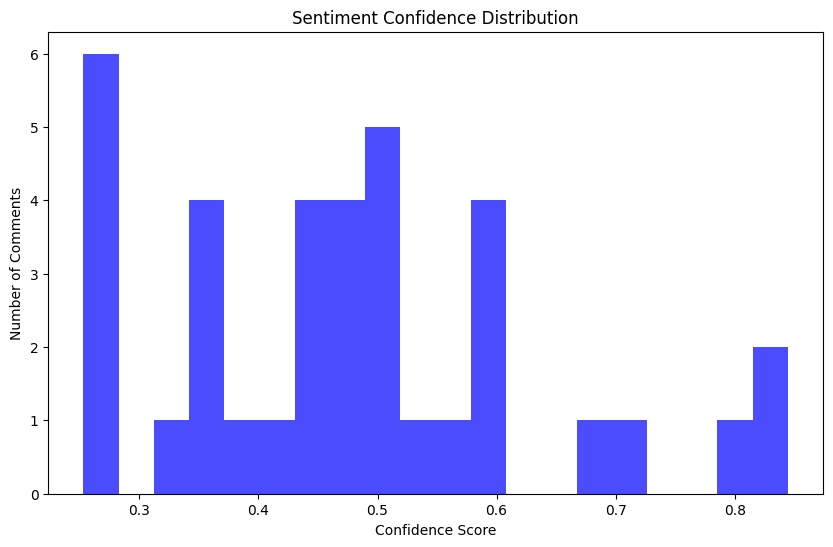

In [12]:
# Confidence distribution
plt.figure(figsize=(10, 6))
plt.hist(comments_df['confidence'], bins=20, color='blue', alpha=0.7)
plt.title('Sentiment Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Comments')
plt.show()

### Word Cloud

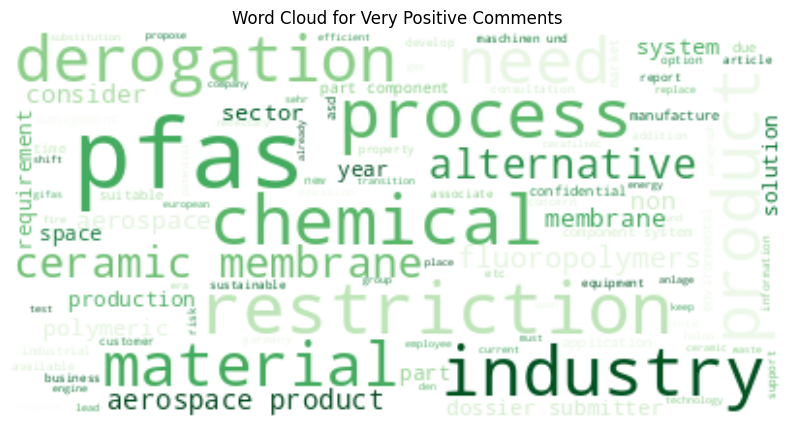

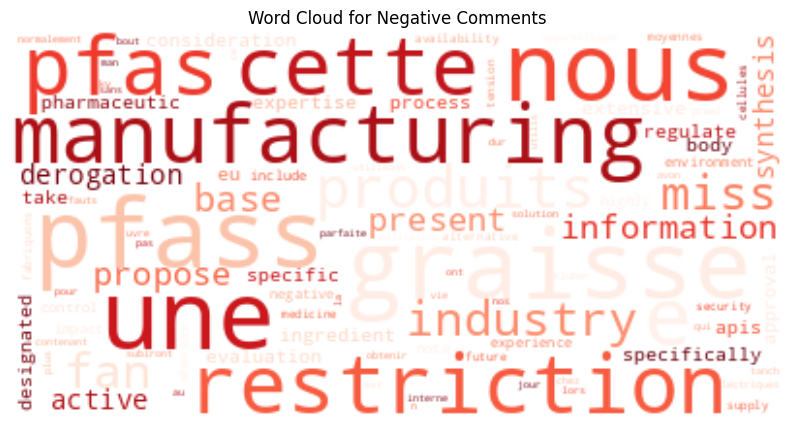

In [28]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Assuming 'comments_df' is your DataFrame with 'cleaned_comments' and 'sentiment' columns
def generate_wordcloud(data, sentiment, colormap):
    text = ' '.join(data[data['sentiment'] == sentiment]['cleaned_comments'])
    stopwords = set(STOPWORDS)
    new_stopwords = ["use", "comment", "would", "also", "get", "even", "could", "make", "see", "give", "de"] # Customize this list
    stopwords.update(new_stopwords)


    # Create and generate a word cloud image:
    wordcloud = WordCloud(
        max_font_size=50,
        max_words=100,
        background_color="white",
        colormap=colormap,
        stopwords=stopwords
    ).generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment} Comments")
    plt.show()

# Generate word clouds for positive and negative sentiments
generate_wordcloud(comments_df, 'Very Positive', 'Greens')
generate_wordcloud(comments_df, 'Negative', 'Reds')

### BERTopic

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
import pandas as pd
comments_df = pd.read_csv('pfas_comments.csv')
comments = comments_df['General Comments'].tolist()
# Create a CountVectorizer to remove stop words and limit vocabulary size
vectorizer_model = CountVectorizer(stop_words="english", max_features=5000)

# Create and fit the BERTopic model
topic_model = BERTopic(vectorizer_model=vectorizer_model)
topics, probabilities = topic_model.fit_transform(comments)

# Get the top 10 topics and their most frequent words
topic_model.get_topic_info()

# Visualize the topics
topic_model.visualize_topics()

# Visualize the topic hierarchy
topic_model.visualize_hierarchy()

In [ ]:
from transformers import pipeline

# Load the classification pipeline with the specified model
pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")

# Classify a new sentence
sentence = "I love this product! It's amazing and works perfectly."
result = pipe(sentence)

# Print the result
print(result)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'Very Positive', 'score': 0.5922621488571167}]
